## Data Preprocessing

In [1]:
from statsmodels.tsa.stattools import coint
from tempdisagg import TempDisaggModel
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('Data/Macro.csv')
data['Exports_numeric'] = pd.to_numeric(data['Exports'], errors='coerce')
data['Imports_numeric'] = pd.to_numeric(data['Imports'], errors='coerce')
data['USDPHP_numeric'] = pd.to_numeric(data['USDPHP'], errors='coerce')

data['Monthly_Trade_PHP'] = (
    data['Exports_numeric'] + data['Imports_numeric']
) * data['USDPHP_numeric']

# Create quarterly trade by summing 3 months
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + 
                             data['Month'].astype(str) + '-01')
data.set_index('Date', inplace=True)

# Resample to quarterly sum
quarterly_trade = data['Monthly_Trade_PHP'].resample('QE').sum()

# Get quarterly GDP (remove NaNs)
quarterly_gdp = data['Nominal GDP'].resample('QE').mean().dropna()

# Align both series on common dates
start, end = "1991-01-01", "2004-12-31"

gdp_series = quarterly_gdp.loc[start:end]
trade_series = quarterly_trade.loc[start:end]

# Test for cointegration
coint(gdp_series, trade_series, autolag='AIC')


(np.float64(-2.3757208699955488),
 np.float64(0.3364386725432962),
 array([-4.10664876, -3.44947826, -3.1224619 ]))

In [52]:
from disaggregation import main
subset = main() 
subset.head()

Disaggregated CSV exists. Loading...


,Unnamed: 3,Inflation,Population,GDP,Imports,Exports,Agriculture,Industry,Services,USDPHP,Nominal GDP,TotalTrade,TotalTrade_PHPMN,NominalGDP_disagg,Pop_disagg
0,1/1/1992,10.9,NaN,NaN,1037.69,662.37,NaN,NaN,NaN,26.5446,NaN,1700.06,45127.41268,136347.8527,63004203.31
1,2/1/1992,9.1,NaN,NaN,1032.51,714.90,NaN,NaN,NaN,26.1580,NaN,1747.41,45708.75078,137765.5289,62965193.58
2,3/1/1992,8.7,NaN,1244652.42,1164.81,898.46,18.11,32.58,49.3,25.8102,362800.0,2063.27,53253.41135,128415.5503,62929730.18
3,4/1/1992,8.4,NaN,NaN,1196.81,666.45,NaN,NaN,NaN,25.6672,NaN,1863.26,47824.66707,120089.5621,62897813.13
4,5/1/1992,8.9,NaN,NaN,1186.29,811.71,NaN,NaN,NaN,26.1496,NaN,1998.00,52246.90080,124258.7011,62869442.41


In [53]:
!python disaggregation.py

Disaggregated CSV exists. Loading...


## Model Building

In [53]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler

import random

import os
import json

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.X) - self.seq_len 
        
    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len])

In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.2):
        super(GRUModel, self).__init__()
        
        # GRU layer
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0  # Changed from dropout to 0
        )
        
        # Add manual dropout layer
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.dropout(out)  # Apply dropout manually here
        out = self.fc(out)
        return out

In [4]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
    def forward(self, predictions, targets):       
        return torch.sqrt(self.mse(predictions, targets) + 1e-6)
        
class MAPELoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(MAPELoss, self).__init__()
        self.epsilon = epsilon  # Small constant to prevent division by zero

    def forward(self, output, target):
        return torch.mean(torch.abs((target - output) / (target + self.epsilon)))*100

In [5]:
class Hyperparameter:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [52]:
def set_seed(seed=None):
    if seed is None:
        seed = 1
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Remove CUDA-specific settings for Mac
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    
    # MPS doesn't need special deterministic settings
    os.environ['PYTHONHASHSEED'] = str(seed)

In [7]:
def split_data(X, use_val=True):
    if use_val:
        train_size = int(0.6 * len(X))
        val_size = int(0.2 * len(X))

        train = X[:train_size]
        val = X[train_size:train_size + val_size]
        test = X[train_size + val_size:]

        return train, val, test

In [46]:
from sklearn.preprocessing import MinMaxScaler
import pickle

def transform_data(data, save_path="scaler.pkl"):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    with open(save_path, "wb") as f:
        pickle.dump(scaler, f)
    
    return data_scaled

def inverse_transform(data, load_path="scaler.pkl"):
    with open(load_path, "rb") as f:
        scaler = pickle.load(f)
    return scaler.inverse_transform(data)

In [47]:
def train_model(model, dataloader, device, optimizer, criterion):

    model.train()
    total_loss = 0.0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    return total_loss / total_samples if total_samples > 0 else 0.0

@torch.no_grad()
def evaluate(model, dataloader, device, criterion, hyperparams):

    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)


        outputs = model(inputs)
        loss = criterion(outputs, targets)

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
        all_preds.append(outputs.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0

    return avg_loss, all_preds

In [48]:
def run(model, train_loader,val_loader,test_loader,device,train_criterion,test_criterion, hyperparams):
    
    set_seed(1)
    optimizer = torch.optim.AdamW(model.parameters(),lr=hyperparams.lr, weight_decay=hyperparams.wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=hyperparams.factor, patience=hyperparams.patience)
    
    train_losses = []
    val_losses = []

    for e in range(hyperparams.epoch):

        train_loss = train_model(model, train_loader, device, optimizer, train_criterion)
        val_loss,_ = evaluate(model, val_loader, device, train_criterion, hyperparams)
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (e + 1) % 100 == 0 or e == 0:
            print(f"Epoch {e+1}/{hyperparams.epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    _, test_preds = evaluate(model, test_loader, device, test_criterion, hyperparams)

    #test_preds_clipped = np.clip(test_preds, train_labels_scaled.min(), train_labels_scaled.max())

    #inversed_test_preds = inverse_transform(test_preds_clipped, "labels_scaled")
    inversed_test_preds = inverse_transform(test_preds, "labels_scaled")
    # Get corresponding actual labels from test_loader 
    actual_labels = []
    for _, targets in test_loader:
        actual_labels.append(targets)
    actual_labels = torch.cat(actual_labels, dim=0).cpu().numpy()
    
    # Inverse transform actual labels too
    inversed_actual = inverse_transform(actual_labels, "labels_scaled")
    
    # Now they match in shape
    test_loss = test_criterion(
        torch.tensor(inversed_test_preds), 
        torch.tensor(inversed_actual)
    )
    
    return test_loss, inversed_test_preds

In [54]:
btr_data = pd.read_csv("Data/cordata.csv")
btr_data = btr_data.set_index("Date")

macro_data = pd.read_csv("Data/disaggregated.csv")
macro_data = macro_data.rename(columns={'Unnamed: 3': 'Date'}).set_index('Date')
macro_data = macro_data[['TotalTrade_PHPMN', 'NominalGDP_disagg', 'Pop_disagg']]

dummy = pd.read_csv("Data/dummy.csv").fillna(0)
dummy = dummy.set_index("Date")

btr_data.index = pd.to_datetime(btr_data.index)
macro_data.index = pd.to_datetime(macro_data.index)
dummy.index = pd.to_datetime(dummy.index)

# keep Jan 1992 onwards
start = "1992-01-01"

btr_data = btr_data.loc[start:]
macro_data = macro_data.loc[start:]
dummy = dummy.loc[start:]

df = btr_data.join(macro_data, how="inner").join(dummy, how="inner")

X = pd.concat(
    [btr_data[['BIR', 'BOC', 'Other Offices']], macro_data, dummy],
    axis=1
).values.copy()
y = df[['BIR', 'BOC', 'Other Offices']].values.copy()

train_data, val_data, test_data = split_data(X)
train_labels, val_labels, test_labels = split_data(y)

In [55]:
with open("config.json", "r") as file:
    config = json.load(file)
hyperparams = Hyperparameter(**config)

In [56]:
train_data_scaled = transform_data(train_data,"train_scaled")
train_labels_scaled = transform_data(train_labels,"labels_scaled")

val_data_scaled = transform_data(val_data,"train_scaled")
val_labels_scaled = transform_data(val_labels,"labels_scaled")

test_data_scaled = transform_data(test_data,"train_scaled")
test_labels_scaled = transform_data(test_labels,"labels_scaled")

train_dataset = TimeSeriesDataset(train_data_scaled, train_labels_scaled, seq_len=hyperparams.seq_len)
val_dataset = TimeSeriesDataset(val_data_scaled, val_labels_scaled, seq_len=hyperparams.seq_len)
test_dataset = TimeSeriesDataset(test_data_scaled, test_labels_scaled, seq_len=hyperparams.seq_len)

train_loader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=False)

In [57]:
set_seed(1)
input_size = train_data.shape[1] 
output_size = train_labels.shape[1]


train_criterion = nn.MSELoss()
test_criterion = MAPELoss()

model = GRUModel(
            input_size=input_size,
            hidden_size=hyperparams.hidden_size,
            output_size=output_size,
            num_layers=hyperparams.num_layers,
            dropout=hyperparams.dropout
        ).to(device)
testloss, preds = run(model, train_loader,val_loader,test_loader,device,train_criterion,test_criterion,hyperparams)

Epoch 1/500 - Train Loss: 0.0353, Val Loss: 0.3776
Epoch 100/500 - Train Loss: 0.0094, Val Loss: 0.0307
Epoch 200/500 - Train Loss: 0.0092, Val Loss: 0.0307
Epoch 300/500 - Train Loss: 0.0097, Val Loss: 0.0307
Epoch 400/500 - Train Loss: 0.0092, Val Loss: 0.0307
Epoch 500/500 - Train Loss: 0.0097, Val Loss: 0.0307


In [62]:
testloss

tensor(20.5501)

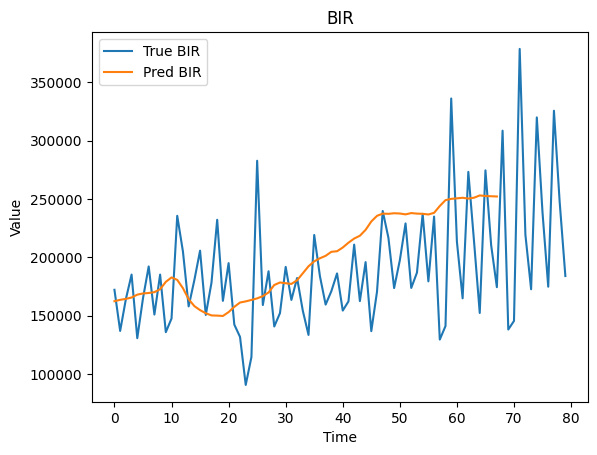

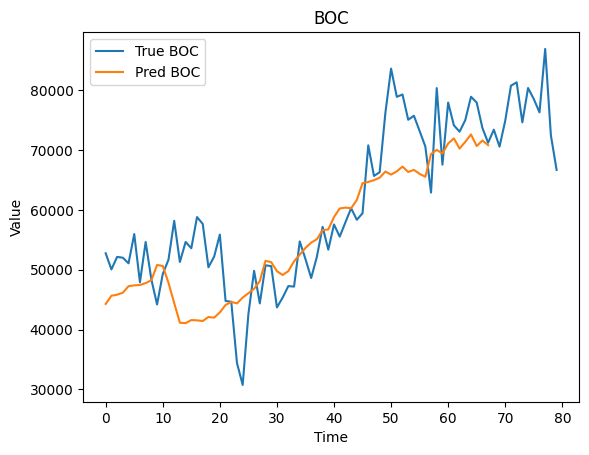

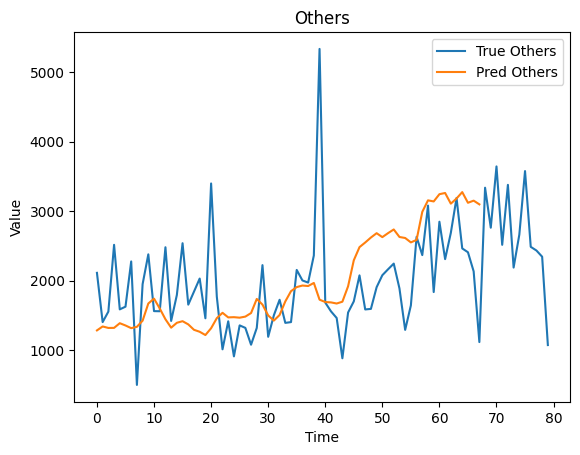

In [65]:
import matplotlib.pyplot as plt

labels = ["BIR","BOC","Others"]
for i in range(3):
    plt.figure()
    plt.plot(test_labels[:, i], label=f"True {labels[i]}")
    plt.plot(preds[:, i], label=f"Pred {labels[i]}")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(labels[i])
    plt.show()